# Moving 3D shapes under bounds and constraints

A sketch of some ideas for a simple system of bounds and constraints (behaviours) to assist with moving objects in simple gemotry scenarios. Anticipated for use in an interactive GUI.

## Vector maths

Minimise dependencies

In [1]:
import math

def vec_add(a, b):
  return tuple([c_a + c_b for c_a, c_b in zip(a, b)])

def vec_sub(a, b):
  return tuple([c_a - c_b for c_a, c_b in zip(a, b)])

def vec_mul(a, m):
  return tuple([m * c for c in a])

def vec_dot(a, b):
  return sum([c_a * c_b for c_a, c_b in zip(a, b)])

## Constraints - primitives

**StickyBoundaryPlane** is an example of a behaviour primitive that could be abstracted and otherwise specialised. Note `bounded_position` and `constrained_move` both take a target vector return the vector that minimises the distance to target while preserving behaviour.

In [2]:
class StickyBoundaryPlane():

  def __init__(self, origin, normal):
    self.origin = origin
    self.normal = normal

  def height(self, x):
    d = vec_sub(x, self.origin)
    return vec_dot(d, self.normal)
  
  def bounded_position(self, x):
    p = x
    h = self.height(x)
    if h < 0:
      h_vec = vec_mul(self.normal, h)
      p = vec_sub(x, h_vec)
    return p

  def constrained_move(self, x):
    h = self.height(x)
    h_vec = vec_mul(self.normal, h)
    return vec_sub(x, h_vec)

  def offset(self, margin):
    return StickyBoundaryPlane(vec_add(self.origin, vec_mul(self.normal, margin)),
                               self.normal)

We define the floor and some sides of a room with StickyBoundaryPlanes

In [3]:
floor = StickyBoundaryPlane((0, 0, 0), (0, 0, 1))
rear_wall = StickyBoundaryPlane((0, 0, 0), (0, 1, 0))
side_wall_right = StickyBoundaryPlane((0, 0, 0), (1, 0, 0))
side_wall_left = StickyBoundaryPlane((3, 0, 0), (-1, 0, 0))

all_behaviours = {floor, rear_wall, side_wall_right, side_wall_left}

## Constraints - composite

Here we create a system of behviours with composite bounds/constraints from multiple primitives. There might be other cases where we have to be smarter about composition.

In [4]:
from functools import reduce

def pair(a, b):
  return lambda x: b(a(x))

def comp(cs):
  return reduce(pair, cs, lambda x: x)

## Determine active constraints

The set of bounds/constraints in place given the current state. In this simple model, bounds depend only on defined behaviours, while constraints also depend on current position. The margin on constraints gives us a kind of _snap-to_ behaviour.

In [5]:
def active_position_bounds(behaviours):
  return set([b.bounded_position for b in behaviours])

In [6]:
def active_move_constraints(w, behaviours):
  margin = 0.5
  active = set()
  for b in behaviours:
    if b.height(w) < margin:
      active.add(b.constrained_move)
  return active 

## Make compliant moves

Move within bounds defined by a set of behaviours

In [7]:
def move_within_bounds(x, behaviours):
  return comp(active_position_bounds(behaviours))(x)

Move within constraints defined by a set of behaviours. Permit a move from a poisition with multiple constraints to a position with fewer constraints if it means relaxing some but not all of the constraints, assuming this is deliberate user intent.

In [8]:
def move_constrained_with_relax(w, x, behaviours):
  initial = active_move_constraints(w, behaviours)
  final = active_move_constraints(x, behaviours)
  relax = len(final) > 0 and final.issubset(initial)
  applied = final if relax else initial
  return comp(applied)(x)

In [9]:
def compliant_move(w, x, behaviours):
  return move_constrained_with_relax(w, move_within_bounds(x, behaviours), behaviours)

## Define 3D shape of an object

The above presumes a point object, or the use of a point on a 3D shape, but now we consider a general 3D shape, defined relatived to the point. **AABB** is another primitive we could abstract and specialise again.

In [10]:
class AABB():

  def __init__(self, min, max):
    self.min = min
    self.max = max

  def vertexes(self):
    lim = [self.min, self.max]
    return set([(i[0], j[1], k[2]) for i in lim for j in lim for k in lim])
  
  def extents(self, dir):
    p = StickyBoundaryPlane((0, 0, 0), dir)
    hs = [p.height(v) for v in self.vertexes()]
    return (min(hs), max(hs))

In [11]:
box = AABB((-0.1, -0.2, -0.3), (0.1, 0.2, 0.3))

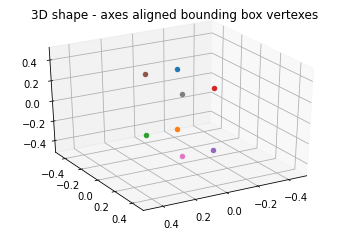

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-0.5, 0.5)
ax.set_ylim3d(-0.5, 0.5)
ax.set_zlim3d(-0.5, 0.5)
for v in box.vertexes():
  ax.scatter(v[0], v[1], v[2])
ax.view_init(30, 60)
plt.title('3D shape - axes aligned bounding box vertexes')
plt.draw()

## Adjust behaviours based on 3D shape

In [13]:
def adjust_behaviours_for_shape(behaviours, shape):
  return set([b.offset(-1 * shape.extents(b.normal)[0]) for b in behaviours])

Note that if we rotate, scale, or otherwise change the shape, we can adjust the behaviours again (we don't do that here)

In [14]:
behaviours_adjusted = adjust_behaviours_for_shape(all_behaviours, box)

for b in behaviours_adjusted:
  print(f'StickyBoundaryPlane orgin {b.origin}, normal {b.normal}')

StickyBoundaryPlane orgin (0.0, 0.2, 0.0), normal (0, 1, 0)
StickyBoundaryPlane orgin (0.0, 0.0, 0.3), normal (0, 0, 1)
StickyBoundaryPlane orgin (0.1, 0.0, 0.0), normal (1, 0, 0)
StickyBoundaryPlane orgin (2.9, 0.0, 0.0), normal (-1, 0, 0)


## Extension ideas

* Add orientation constraints to the behaviours so that objects also conform to allowed orientations under certain conditions
* Create a StickyStrip or StickyRect as a region on the StickyBoundaryPlane to support more complex room geometries, extend to further primitives...
* Create behaviours based on objects in the room so as to limit the relative positions and orientations of pairs of objects
* Interactive version!
* etc

# Now some examples of moves

Choose either the original or adjusted behaviours. Note that the end position of moves with adjusted behaviours should reflect the constraints and the extents of the 3D shape defined above.

In [15]:
behaviour_set = behaviours_adjusted

Attempt move from current position `w` to target `x`

In [16]:
# move up the wall from the edge
w = (1.5, 0, 0)
x = (1, 0, 2)
compliant_move(w, x, behaviour_set)

(1.0, 0.2, 2.0)

Plot an attempted move and the resultant position

(1.0, 0.2, 2.0)

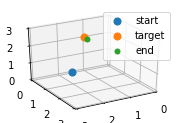

In [17]:
def vis(w, x, draw_legend=False):
  y = compliant_move(w, x, behaviour_set)
  fig = plt.figure()
  fig.set_figheight(2)
  fig.set_figwidth(3)
  ax = fig.add_subplot(111, projection='3d')
  ax.set_xlim3d(0, 3)
  ax.set_ylim3d(0, 3)
  ax.set_zlim3d(0, 3)
  ax.scatter(w[0], w[1], w[2], s=50)
  ax.scatter(x[0], x[1], x[2], s=50)
  ax.scatter(y[0], y[1], y[2], s=25)
  if draw_legend:
    plt.legend(['start', 'target', 'end'])
  ax.view_init(30, 60)
  plt.draw()
  return y

vis(w, x, draw_legend=True)

(2, 2, 2)

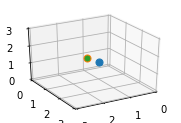

In [18]:
# move in free space
vis((1, 1, 1), (2, 2, 2))

(2.0, 2.0, 0.30000000000000004)

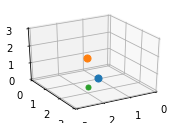

In [19]:
# try to move into space, resolves to move along floor
vis((1, 1, 0), (2, 2, 2))

(2.0, 0.2, 0.3)

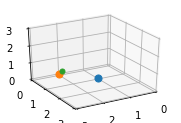

In [20]:
# move along floor to edge
vis((1, 1, 0), (2, 0, 0))

(1.0, 0.2, 2.0)

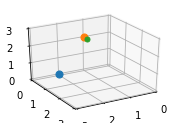

In [21]:
# move from edge up wall
vis((2, 0, 0), (1, 0, 2))

(1.0, 0.2, 0.3)

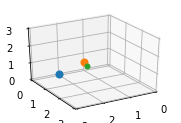

In [22]:
# snap to edges
vis((2, 0, 0), (1, 0, 0.5))

(0.10000000000000009, 0.19999999999999996, 0.30000000000000004)

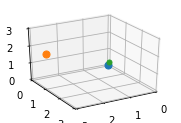

In [23]:
# can't exit corner into space
vis((0, 0, 0), (3, 1, 2))

(0.1, 2.0, 0.3)

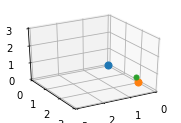

In [24]:
# can exit corner on edge
vis((0, 0, 0), (0, 2, 0))

(2.0, 1.0, 0.3)

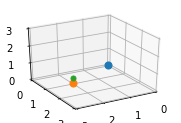

In [25]:
# can exit corner on face
vis((0, 0, 0), (2, 1, 0))

(0.10000000000000009, 1.0, 0.3)

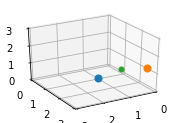

In [26]:
# can't move out of bounds on constraint
vis((1, 1, 0), (-1, 1, 0))

(0.10000000000000009, 1.0, 0.30000000000000004)

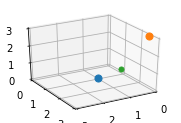

In [27]:
# can't move out of bounds and off constraint
vis((1, 1, 0), (-1, 1, 2))

(2.9, 0.2, 0.3)

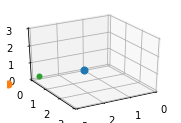

In [28]:
# can't move out of bounds along edge
vis((1, 0, 0), (4, 0, 0))